# Debugging the user facing API

Starting revno: 777cc59c2b06ceeb0a22d670b982342240bc00e9
fixed bugs with: 00b99d096a8db08b986fa188e878a1901fb8d9ea


In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from functools import partial

from src.integration.default_integrator import Integrator
from src import setup_std_stream_logger

In [2]:
setup_std_stream_logger(debug=True)
device=torch.device("cuda:7")

In [3]:
def nonzerocos(x):
    return torch.cos(4*(x[:,0]+x[:,1]))**2

In [51]:
integrator = Integrator(d=2,f=nonzerocos,loss="variance",
                        trainer_options={"n_epochs":10,"minibatch_size":20000,"optim":partial(torch.optim.Adam,lr=1.e-3)},
                        flow_options={"cell_params":{"n_bins":300}},
                        verbosity=3,trainer_verbosity=1,device=device)

In [52]:
result = integrator.integrate(50,1)

Starting integration
Initializing the survey phase
Starting the survey phase
Integral: 4.964e-01 +/- 1.111e-03
Integral: 4.997e-01 +/- 1.110e-03
Integral: 4.977e-01 +/- 1.109e-03
Integral: 4.952e-01 +/- 1.112e-03
Integral: 4.981e-01 +/- 1.110e-03
Integral: 4.966e-01 +/- 1.112e-03
Integral: 4.974e-01 +/- 1.109e-03
Integral: 4.963e-01 +/- 1.113e-03
Integral: 4.968e-01 +/- 1.112e-03
Integral: 4.979e-01 +/- 1.109e-03
Integral: 4.974e-01 +/- 1.110e-03
Integral: 4.949e-01 +/- 1.107e-03
Integral: 4.975e-01 +/- 1.109e-03
Integral: 4.974e-01 +/- 1.111e-03
Integral: 4.953e-01 +/- 1.109e-03
Integral: 4.989e-01 +/- 1.113e-03
Integral: 4.968e-01 +/- 1.111e-03
Integral: 4.978e-01 +/- 1.110e-03
Integral: 4.969e-01 +/- 1.110e-03
Integral: 4.973e-01 +/- 1.110e-03
Finalizing the survey phase
Initializing the refine phase
Starting the refine phase
Integral: 4.974e-01 +/- 1.793e-04
Finalizing the refine phase
Final result: 4.97366e-01 +/- 1.79300e-04


flat: 0.4990702271461487 with var 0.12315355241298676
model: 0.49727025628089905 with var 0.003225745167583227
speed-up: 38.17832565307617




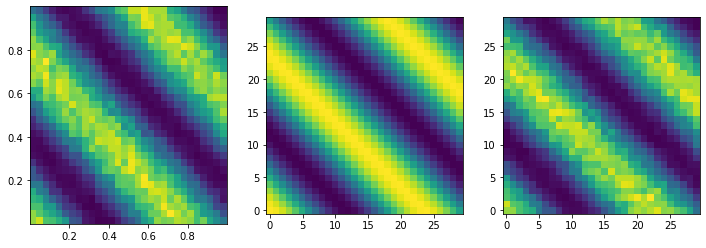

In [53]:
x,px,fx = integrator.sample_survey()
varf,meanf = torch.var_mean(fx/px)
print(f"flat: {meanf} with var {varf}")
x,px,fx = integrator.sample_refine()
var,mean = torch.var_mean(fx/px)
print(f"model: {mean} with var {var}")
print(f"speed-up: {varf/var}")
print("\n")

x,px,fx=integrator.sample_refine(n_points=100000)
fig, axs = plt.subplots(1,3)
fig.set_size_inches((12,4))
n=30
h2=axs[0].hist2d(x[:,0].cpu().numpy(),x[:,1].cpu().numpy(),bins=n)
axs[1].imshow(nonzerocos(torch.cartesian_prod(torch.arange(0,1,1/n),torch.arange(0,1,1/n))).reshape(n,n).numpy(),origin="lower",)
axs[2].imshow(h2[0],origin="lower")
plt.show()

In [58]:
# This is still a problem in 00b99d096a8db08b986fa188e878a1901fb8d9ea

integrator = Integrator(d=2,f=nonzerocos,flow="realnvp",loss="variance",
                        trainer_options={"n_epochs":10,"minibatch_size":20000,"optim":partial(torch.optim.Adam,lr=1.e-6)},
                        verbosity=3,trainer_verbosity=1,device=device)

result = integrator.integrate(1,1)



Starting integration
Initializing the survey phase
Starting the survey phase


Caught error:
loss value nan is not valid
Cannot reset to a previous checkpoint
loss value nan is not valid


InvalidLossError: loss value nan is not valid

In [7]:
# The problem is with the variance loss, not with the model
integrator = Integrator(d=2,f=nonzerocos,flow="realnvp",loss="dkl",
                        trainer_options={"n_epochs":100,"minibatch_size":20000,"optim":partial(torch.optim.Adam,lr=1.e-3)},
                        flow_options={"cell_params":{"n_hidden":16}},
                        verbosity=3,trainer_verbosity=1,device=device)

result = integrator.integrate(5,1)

Starting integration
Initializing the survey phase
Starting the survey phase
Integral: 4.964e-01 +/- 1.111e-03
Integral: 4.960e-01 +/- 1.108e-03
Integral: 4.975e-01 +/- 1.109e-03
Integral: 4.967e-01 +/- 1.110e-03
Integral: 4.957e-01 +/- 1.108e-03
Finalizing the survey phase
Initializing the refine phase
Starting the refine phase
Integral: 4.972e-01 +/- 5.624e-04
Finalizing the refine phase
Final result: 4.97163e-01 +/- 5.62406e-04


flat: 0.49801698327064514 with var 0.12297399342060089
model: 0.49763724207878113 with var 0.02480446919798851
speed-up: 4.957735538482666




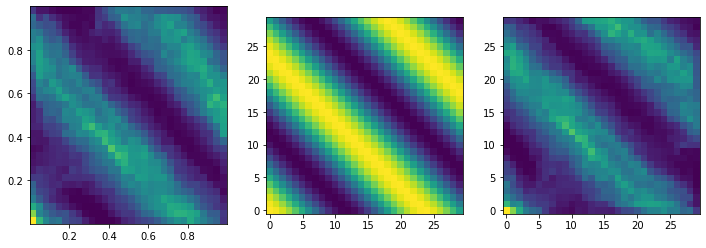

In [8]:
x,px,fx = integrator.sample_survey()
varf,meanf = torch.var_mean(fx/px)
print(f"flat: {meanf} with var {varf}")
x,px,fx = integrator.sample_refine()
var,mean = torch.var_mean(fx/px)
print(f"model: {mean} with var {var}")
print(f"speed-up: {varf/var}")
print("\n")

x,px,fx=integrator.sample_refine(n_points=100000)
fig, axs = plt.subplots(1,3)
fig.set_size_inches((12,4))
n=30
h2=axs[0].hist2d(x[:,0].cpu().numpy(),x[:,1].cpu().numpy(),bins=n)
axs[1].imshow(nonzerocos(torch.cartesian_prod(torch.arange(0,1,1/n),torch.arange(0,1,1/n))).reshape(n,n).numpy(),origin="lower",)
axs[2].imshow(h2[0],origin="lower")
plt.show()